In [8]:
%%bash

pip3.6 install pandas gender_guesser

tensorflow-tensorboard 0.1.2 has requirement bleach==1.5.0, but you'll have bleach 2.1.3 which is incompatible.
tensorflow-tensorboard 0.1.2 has requirement html5lib==0.9999999, but you'll have html5lib 1.0.1 which is incompatible.
chatterbot 0.8.7 has requirement python-dateutil<2.7,>=2.6, but you'll have python-dateutil 2.7.3 which is incompatible.
You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pandas as pd
import gender_guesser.detector as gender
import numpy as np

In [2]:
df = pd.read_csv('nj_teachers_salaries_2016.csv')
median = df['salary'].median()
df['greater_than_median'] = [s > median for s in df['salary']]
d = gender.Detector()
df['possible_gender'] = [d.get_gender(n.split(" ")[0]).replace("mostly_", "").replace("andy", "unknown") for n in df['first_name']]
df = df[df['possible_gender'] != 'unknown']
df = df.dropna()

df.head()

,last_name,first_name,county,district,school,primary_job,fte,salary,certificate,subcategory,teaching_route,highly_qualified,experience_district,experience_nj,experience_total,greater_than_median,possible_gender
0,Heckman,William,Atlantic,Atlantic City,Pennsylvania Ave School,Mathematics Grades 5 - 8,1.0,98774,Standard certificate,General ed,Traditional,Not highly qualified,13.0,13.0,13.0,True,male
1,Bird,Kelly,Atlantic,Atlantic City,Atlantic City High School,Coordinator Substance Abuse,1.0,118415,Standard certificate,General ed,Traditional,Doesn't need to be highly qualified,16.0,16.0,16.0,True,female
2,Bean,David B,Atlantic,Atlantic City,Atlantic City High School,Health & Physical Education,0.8,98774,Standard certificate,General ed,Traditional,Doesn't need to be highly qualified,13.0,13.0,15.0,True,male
3,Campo,Paula Mia,Atlantic,Atlantic City,Atlantic City High School,Resource Program In-class,1.0,66184,Standard certificate,Special ed,Alternate,Doesn't need to be highly qualified,16.0,16.0,16.0,False,female
4,Adams-meyer,Della L,Atlantic,Atlantic City,Atlantic City High School,School Psychologist,1.0,101866,Standard certificate,General ed,Traditional,Doesn't need to be highly qualified,12.0,12.0,12.0,True,female


In [3]:
total_high_paid_men = len(df[(df['possible_gender'] == 'male') & (df['greater_than_median'] == True)])
total_men = len(df[df['possible_gender'] == 'male'])

print("Total Men:", total_men)
print("Chances a man is high paid:", "%0.2f" % (total_high_paid_men / total_men * 100), "%")

total_high_paid_women = len(df[(df['possible_gender'] == 'female') & (df['greater_than_median'] == True)])
total_women = len(df[df['possible_gender'] == 'female'])

print("\nTotal Women:", total_women)
print("Chances a woman is high paid:", "%0.2f" % (total_high_paid_women / total_women * 100), "%")

Total Men: 32624
Chances a man is high paid: 56.10 %

Total Women: 97473
Chances a woman is high paid: 48.66 %


In [4]:
def hist(df, by, column):
    df.groupby(by)[column].value_counts()\
        .sort_index()\
        .unstack()\
        .plot.bar(subplots=True,layout=(1,3),figsize=(14,3),legend=None)
    
hist(df, by='teaching_route', column='possible_gender')
hist(df, by='subcategory', column='possible_gender')
hist(df, by='highly_qualified', column='possible_gender')
hist(df, by='certificate', column='possible_gender')
hist(df, by='experience_total', column='possible_gender')

In [5]:
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import keras as ke
import keras.backend as K
from keras.layers import Input, Dense, Dropout
from keras.models import Model

print(f"sklearn: {sk.__version__}")
print(f"pandas: {pd.__version__}")
print(f"keras: {ke.__version__}")

Using TensorFlow backend.


sklearn: 0.19.1
pandas: 0.23.4
keras: 2.1.5


In [26]:
X = df[["primary_job", "fte", "certificate", "subcategory", "teaching_route",
        "highly_qualified", "experience_district", "experience_nj", "experience_total", "possible_gender"]]
y = df["greater_than_median"].astype(int)
Z = df[["possible_gender"]]

def hot_encode(df, cols):
    for col in cols:
        df = pd.concat([df,pd.get_dummies(df[col], prefix=col)],axis=1).drop([col],axis=1)
    return df
    
X = hot_encode(X, ["primary_job", "certificate", "subcategory", "teaching_route", "highly_qualified", "possible_gender"])
Z = hot_encode(Z, ["possible_gender"])#.drop(["possible_gender_male"],axis=1)

In [27]:
# split into train/test set
X_train, X_test, y_train, y_test, Z_train, Z_test = train_test_split(X, y, Z, test_size=0.3, 
                                                                     stratify=y, random_state=42)

X_train.head()

,fte,experience_district,experience_nj,experience_total,primary_job_Administrative Assistant To District Superintendent,primary_job_Adult High School Principal,primary_job_Advertising,primary_job_Agricultural Occupations,primary_job_Agricultural Technology,primary_job_Air Conditioning & Refrigeration,...,highly_qualified_Doesn't need to be highly qualified,"highly_qualified_Highly qualified, House Matrix",highly_qualified_Highly qualified. Has 30 credits in content area.,highly_qualified_Highly qualified. Has gradate or undergraduate degree in subject area.,highly_qualified_Highly qualified. National Board Certified.,highly_qualified_Highly qualified. Passed the Praxis/NTE,highly_qualified_Nationally Board Certified,highly_qualified_Not highly qualified,possible_gender_female,possible_gender_male
38792,1.0,15.0,15.0,15.0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,0
78812,0.5,1.0,2.0,2.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
74215,1.0,21.0,21.0,21.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
129102,1.0,14.0,14.0,14.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
103851,1.0,32.0,32.0,32.0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


In [8]:
def nn_classifier(n_features):
    inputs = Input(shape=(n_features,))
    dense1 = Dense(32, activation='relu')(inputs)
    dropout1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(dense2)
    outputs = Dense(1, activation='sigmoid')(dropout2)
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model

# initialise NeuralNet Classifier
clf = nn_classifier(n_features=X_train.shape[1])

# train on train set
history = clf.fit(X_train.values, y_train.values, epochs=3, verbose=1)

Epoch 1/3
91067/91067 [==============================] - 21s 235us/step - loss: 0.3828
Epoch 2/3
91067/91067 [==============================] - 22s 238us/step - loss: 0.3589
Epoch 3/3
91067/91067 [==============================] - 22s 241us/step - loss: 0.3549


In [9]:
# predict on test set
y_pred = pd.Series(clf.predict(X_test.values).ravel(), index=y_test.index)
print(f"ROC AUC: {roc_auc_score(y_test, y_pred):.2f}")
print(f"Accuracy: {100*accuracy_score(y_test, (y_pred>0.5)):.1f}%")

ROC AUC: 0.92
Accuracy: 84.5%


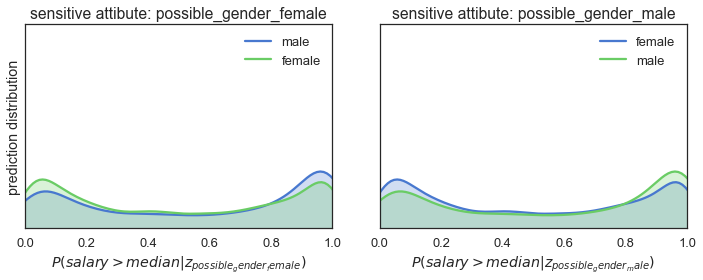

In [32]:
np.random.seed(7)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white", palette="muted", color_codes=True, context="talk")
from IPython import display
%matplotlib inline

def plot_distributions(y, Z, iteration=None, val_metrics=None, p_rules=None, fname=None):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    legend={'possible_gender_female': ['male','female'],
            'possible_gender_male': ['female','male']}
    for idx, attr in enumerate(Z.columns):
        for attr_val in [0, 1]:
            ax = sns.distplot(y[Z[attr] == attr_val], hist=False, 
                              kde_kws={'shade': True,},
                              label='{}'.format(legend[attr][attr_val]), 
                              ax=axes[idx])
        ax.set_xlim(0,1)
        ax.set_ylim(0,7)
        ax.set_yticks([])
        ax.set_title("sensitive attibute: {}".format(attr))
        if idx == 0:
            ax.set_ylabel('prediction distribution')
        ax.set_xlabel(r'$P({{salary>median}}|z_{{{}}})$'.format(attr))
    if iteration:
        fig.text(1.0, 0.9, f"Training iteration #{iteration}", fontsize='16')
    if val_metrics is not None:
        fig.text(1.0, 0.65, '\n'.join(["Prediction performance:",
                                       f"- ROC AUC: {val_metrics['ROC AUC']:.2f}",
                                       f"- Accuracy: {val_metrics['Accuracy']:.1f}"]),
                 fontsize='16')
    if p_rules is not None:
        fig.text(1.0, 0.4, '\n'.join(["Satisfied p%-rules:"] +
                                     [f"- {attr}: {p_rules[attr]:.0f}%-rule" 
                                      for attr in p_rules.keys()]), 
                 fontsize='16')
    fig.tight_layout()
    if fname is not None:
        plt.savefig(fname, bbox_inches='tight')
    return fig

fig = plot_distributions(y_pred, Z_test)

In [11]:
def p_rule(y_pred, z_values, threshold=0.5):
    y_z_1 = y_pred[z_values == 1] > threshold if threshold else y_pred[z_values == 1]
    y_z_0 = y_pred[z_values == 0] > threshold if threshold else y_pred[z_values == 0]
    odds = y_z_1.mean() / y_z_0.mean()
    return np.min([odds, 1/odds]) * 100

print("The classifier satisfies the following %p-rules:")
print(f"\tgiven attribute sex;  {p_rule(y_pred, Z_test['possible_gender_female']):.0f}%-rule")

The classifier satisfies the following %p-rules:
	given attribute sex;  85%-rule


In [24]:
class FairClassifier(object):
    
    def __init__(self, n_features, n_sensitive, lambdas):
        self.lambdas = lambdas
        
        clf_inputs = Input(shape=(n_features,))
        adv_inputs = Input(shape=(1,))
        
        clf_net = self._create_clf_net(clf_inputs)
        adv_net = self._create_adv_net(adv_inputs, n_sensitive)
        self._trainable_clf_net = self._make_trainable(clf_net)
        self._trainable_adv_net = self._make_trainable(adv_net)
        self._clf = self._compile_clf(clf_net)
        self._clf_w_adv = self._compile_clf_w_adv(clf_inputs, clf_net, adv_net)
        self._adv = self._compile_adv(clf_inputs, clf_net, adv_net, n_sensitive)
        self._val_metrics = None
        self._fairness_metrics = None
        
        self.predict = self._clf.predict
        
    def _make_trainable(self, net):
        def make_trainable(flag):
            net.trainable = flag
            for layer in net.layers:
                layer.trainable = flag
        return make_trainable
        
    def _create_clf_net(self, inputs):
        dense1 = Dense(32, activation='relu')(inputs)
        dropout1 = Dropout(0.2)(dense1)
        dense2 = Dense(32, activation='relu')(dropout1)
        dropout2 = Dropout(0.2)(dense2)
        outputs = Dense(1, activation='sigmoid', name='y')(dropout2)
        return Model(inputs=[inputs], outputs=[outputs])
        
    def _create_adv_net(self, inputs, n_sensitive):
        dense1 = Dense(32, activation='relu')(inputs)
        dense2 = Dense(32, activation='relu')(dense1)
        outputs = [Dense(1, activation='sigmoid')(dense2) for _ in range(n_sensitive)]
        return Model(inputs=[inputs], outputs=outputs)

    def _compile_clf(self, clf_net):
        clf = clf_net
        self._trainable_clf_net(True)
        clf.compile(loss='binary_crossentropy', optimizer='adam')
        return clf
        
    def _compile_clf_w_adv(self, inputs, clf_net, adv_net):
        clf_w_adv = Model(inputs=[inputs], outputs=[clf_net(inputs)]+adv_net(clf_net(inputs)))
        self._trainable_clf_net(True)
        self._trainable_adv_net(False)
        loss_weights = [1.]+[-lambda_param for lambda_param in self.lambdas]
        clf_w_adv.compile(loss=['binary_crossentropy']*(len(loss_weights)), 
                          loss_weights=loss_weights,
                          optimizer='adam')
        return clf_w_adv

    def _compile_adv(self, inputs, clf_net, adv_net, n_sensitive):
        adv = Model(inputs=[inputs], outputs=adv_net(clf_net(inputs)))
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        adv.compile(loss=['binary_crossentropy']*n_sensitive, optimizer='adam')
        return adv

    def _compute_class_weights(self, data_set):
        class_values = [0, 1]
        class_weights = []
        if len(data_set.shape) == 1:
            balanced_weights = compute_class_weight('balanced', class_values, data_set)
            class_weights.append(dict(zip(class_values, balanced_weights)))
        else:
            n_attr =  data_set.shape[1]
            for attr_idx in range(n_attr):
                balanced_weights = compute_class_weight('balanced', class_values,
                                                        np.array(data_set)[:,attr_idx])
                class_weights.append(dict(zip(class_values, balanced_weights)))
        return class_weights
    
    def _compute_target_class_weights(self, y):
        class_values  = [0,1]
        balanced_weights =  compute_class_weight('balanced', class_values, y)
        class_weights = {'y': dict(zip(class_values, balanced_weights))}
        return class_weights
        
    def pretrain(self, x, y, z, epochs=10, verbose=0):
        self._trainable_clf_net(True)
        self._clf.fit(x.values, y.values, epochs=epochs, verbose=verbose)
        self._trainable_clf_net(False)
        self._trainable_adv_net(True)
        class_weight_adv = self._compute_class_weights(z)
        self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), class_weight=class_weight_adv, 
                      epochs=epochs, verbose=verbose)
        
    def fit(self, x, y, z, validation_data=None, T_iter=250, batch_size=128,
            save_figs=False):
        n_sensitive = z.shape[1]
        if validation_data is not None:
            x_val, y_val, z_val = validation_data

        class_weight_adv = self._compute_class_weights(z)
        class_weight_clf_w_adv = [{0:1., 1:1.}]+class_weight_adv
        self._val_metrics = pd.DataFrame()
        self._fairness_metrics = pd.DataFrame()  
        for idx in range(T_iter):
            if validation_data is not None:
                y_pred = pd.Series(self._clf.predict(x_val).ravel(), index=y_val.index)
                self._val_metrics.loc[idx, 'ROC AUC'] = roc_auc_score(y_val, y_pred)
                self._val_metrics.loc[idx, 'Accuracy'] = (accuracy_score(y_val, (y_pred>0.5))*100)
                for sensitive_attr in z_val.columns:
                    self._fairness_metrics.loc[idx, sensitive_attr] = p_rule(y_pred,
                                                                             z_val[sensitive_attr])
                display.clear_output(wait=True)
                plot_distributions(y_pred, z_val, idx+1, self._val_metrics.loc[idx],
                                   self._fairness_metrics.loc[idx], 
                                   fname=f'output/{idx+1:08d}.png' if save_figs else None)
                plt.show(plt.gcf())
            
            # train adverserial
            self._trainable_clf_net(False)
            self._trainable_adv_net(True)
            self._adv.fit(x.values, np.hsplit(z.values, z.shape[1]), batch_size=batch_size, 
                          class_weight=class_weight_adv, epochs=1, verbose=0)
            
            # train classifier
            self._trainable_clf_net(True)
            self._trainable_adv_net(False)
            indices = np.random.permutation(len(x))[:batch_size]
            self._clf_w_adv.train_on_batch(x.values[indices], 
                                           [y.values[indices]]+np.hsplit(z.values[indices], n_sensitive),
                                           class_weight=class_weight_clf_w_adv)

In [29]:
# initialise FairClassifier
clf = FairClassifier(n_features=X_train.shape[1], n_sensitive=Z_train.shape[1],
                     lambdas=[30.,30.])

# pre-train both adverserial and classifier networks
clf.pretrain(X_train, y_train, Z_train, verbose=1, epochs=3)

Epoch 1/3
91067/91067 [==============================] - 24s 260us/step - loss: 0.3827
Epoch 2/3
91067/91067 [==============================] - 23s 255us/step - loss: 0.3570
Epoch 3/3
91067/91067 [==============================] - 23s 256us/step - loss: 0.3543
Epoch 1/3
91067/91067 [==============================] - 32s 349us/step - loss: 1.3774 - model_35_loss: 0.6887
Epoch 2/3
91067/91067 [==============================] - 32s 347us/step - loss: 1.3747 - model_35_loss: 0.6873
Epoch 3/3
91067/91067 [==============================] - 32s 346us/step - loss: 1.3744 - model_35_loss: 0.6872


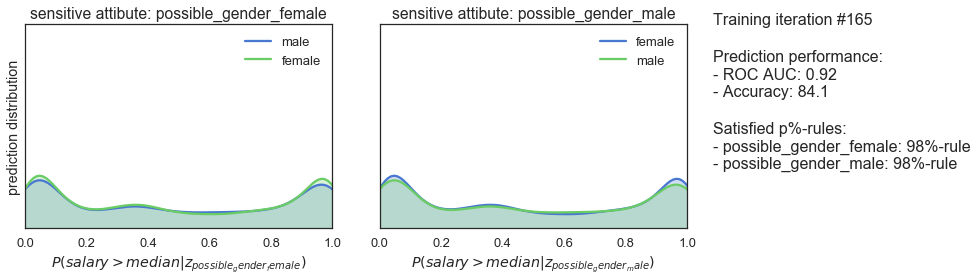

In [33]:
clf.fit(X_train, y_train, Z_train, 
        validation_data=(X_test, y_test, Z_test),
        T_iter=165)